In [0]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,LeakyReLU,Input
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm_notebook
from time import time

In [0]:
parent_dir="/content/drive/My Drive/Colab Notebooks/GANs/"                            #to be changed if run on different computers

In [0]:
x_train=mnist.load_data()[0][0]                                #we only need the images, not the labels

In [4]:
x_train.shape

(60000, 28, 28)

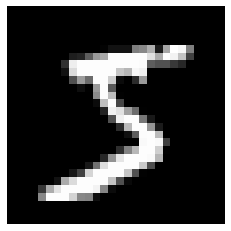

In [5]:
x_train=(x_train.astype("float")-(255/2))/(255/2)                #this converts pixel values from range of [0,255] to [-1,1]

#sample image display:

plt.imshow(x_train[0],cmap="gray")
plt.axis("off")
plt.show()

In [6]:
x_train=x_train.reshape(-1,x_train.shape[1]*x_train.shape[2])
x_train.shape

(60000, 784)

###### Defining Some Constants:


In [0]:
epochs=100               #we will run the entire training process (training of generator+training of discriminator) for these many epochs
batch_size=256           #the no. of images in each batch that will be passed to discriminator
n_batches=int(x_train.shape[0]/batch_size)                     #total no. of batches that will be passed to discriminator in 1 epoch
noise_dim=100            #dimensions of the inital noise vector that we will pass to the generator

opt=Adam(lr=0.0002,beta_1=0.5)                                 #these parameters have been found to work well with GANs in practice

# Defining the Generator and Discriminator Models:

In [8]:
gen=Sequential()

gen.add(Dense(256,input_shape=(noise_dim,)))
gen.add(LeakyReLU(0.2))                                        #alpha=0.2 (this means that for z<0, output of leakyrelu(z) will be 0.2*x)

gen.add(Dense(512))
gen.add(LeakyReLU(0.2))

gen.add(Dense(1024))
gen.add(LeakyReLU(0.2))

gen.add(Dense(x_train.shape[1],activation="tanh"))

gen.compile(loss="binary_crossentropy",optimizer=opt)
gen.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 784)               8

In [9]:
disc=Sequential()

disc.add(Dense(512,input_shape=(x_train.shape[1],)))
disc.add(LeakyReLU(0.2))

disc.add(Dense(256))
disc.add(LeakyReLU(0.2))

disc.add(Dense(1,activation="sigmoid"))

disc.compile(loss="binary_crossentropy",optimizer=opt)
disc.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


# Connecting the Generator and Discriminator Models using keras functional API

In [10]:
disc.trainable=False

gan_input=Input(shape=(noise_dim,))                                 #input to the Generative Adverserial Network
img=gen(gan_input)                                                  #Image generated by the generator (output of the generator)
gan_output=disc(img)                                                #output of the discriminator

model=Model(gan_input,gan_output)                                   #Model is used to call the keras functional api and build a model using the defined layers or input/output
model.compile(loss="binary_crossentropy",optimizer=opt)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 784)               1486352   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 533505    
Total params: 2,019,857
Trainable params: 1,486,352
Non-trainable params: 533,505
_________________________________________________________________


#### A function to plot the images after each epoch

In [0]:
def plot_imgs(epoch,n_images=100):                         #n_images specifies how mnay images u want to plot

    noise=np.random.normal(size=(n_images,noise_dim))
    generated_imgs=gen.predict(noise)
    generated_imgs=generated_imgs.reshape(-1,int(x_train.shape[1]**0.5),int(x_train.shape[1]**0.5))

    plt.figure(figsize=(10,10))

    for i in range(n_images):
        plt.subplot(10,10,i+1)
        plt.imshow(generated_imgs[i],cmap="gray")
        plt.axis("off")
    plt.show()

# Training the Generator and Discriminator:


In [12]:
gloss=[]
dloss=[]
#we will later use these to plot generator and disciminator losses

for i in tqdm_notebook(range(epochs)):

    gen_loss=0
    disc_loss=0

    for step in range(n_batches):

        #Training the Discriminator:       (generator is frozen (non-trainable))

        random_indices=np.random.randint(low=0,high=x_train.shape[0],size=int(batch_size/2))
        #we will take images corresponding to these indices from the training data as the real images for the current batch
        real_imgs=x_train[random_indices]
        real_labels=np.ones(real_imgs.shape[0])*0.9                          
        #labels are multiplied with 0.9 for smoothing labels of discriminator (watch video)

        noise=np.random.normal(0,1,size=(int(batch_size/2),noise_dim))         
        #this will give us batch_size/2 no. of random noise samples, each being a vector of size noise_dim
        fake_imgs=gen.predict(noise)  
        fake_labels=np.zeros(fake_imgs.shape[0])        
        #after passing the noise samples through the generator network, we get images as output, each having a shape of (28,28)
        #,identical to the shape of the real images. Also, the total no. of fake images=no. of real images=batch_size/2

        imgs=np.vstack((real_imgs,fake_imgs))
        labels=np.hstack((real_labels,fake_labels))

        disc_loss+=disc.train_on_batch(imgs,labels)                 #training the discriminator on current batch

        #Training the Generator:       (discriminator is frozen (non-trainable) (as we are using model (while defining model, we forze disc)))
        noise=np.random.normal(0,1,size=(batch_size,noise_dim))        
        #generating batch_size no. of random noise vectors, each of size noise_dim
        true_labels=np.ones(batch_size)                             #y_true for discriminator output
        gen_loss+=model.train_on_batch(noise,true_labels)

    print("Epoch: ",i," Average Discriminator Loss: ",disc_loss/n_batches," Average Generator Loss: ",gen_loss/n_batches)

    gloss.append(gen_loss/n_batches)
    dloss.append(disc_loss/n_batches)

    plot_imgs(i)

    if i>0 and gloss[-2]>gloss[-1]:
        gen.save(parent_dir+"mnist_generator.h5")

Output hidden; open in https://colab.research.google.com to view.

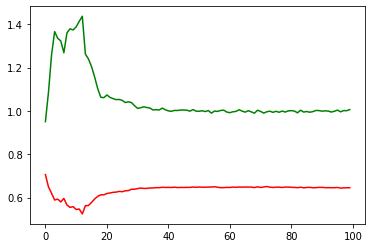

In [13]:
e=np.arange(epochs)
plt.plot(e,gloss,c="g")
plt.plot(e,dloss,c="r")

plt.show()